# Trading Strategies powered by Machine Learning - Support_Vector_Classifier

## Support_Vector_Classifier with scikit-learn 

In [24]:
import sys
sys.path.append('../../')

In [25]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [26]:
from backtesting import Strategy
from sklearn import svm
from sklearn import preprocessing

## Getting the Data

In [27]:
XAUUSD = load_data()

In [28]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [29]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [30]:
class Support_Vector_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [31]:
strategy = Support_Vector_Classifier
account_size = 1000
folder_ML_Strategy = 'Support Vector Classifier'

In [32]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
from util.ATR import *
from util.SMA import *
from util.RSI import *
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_SVC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        df['ATR'] = ATR(df, 20)['ATR']

        periods = 14
        moving_av = 3

        df["roll_low"] = df['Low'].rolling(periods).min()
        df["roll_high"] = df['High'].rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100
        df["D"] = df.K.rolling(moving_av).mean()

        df = df.drop('roll_low', axis=1)
        df = df.drop('roll_high', axis=1)

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['Signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        df = df.dropna()

        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        # Ensure 'Signal' column exists in data_train
        if 'Signal' not in self.data_train.columns:
            raise ValueError("'Signal' column is missing in data_train")

        # Define features and target columns
        features = ['rsi14', 'ATR', 'K', 'D']
        target = 'Signal'

        # Prepare data for model training
        X_train = self.data_train[features]
        y_train = self.data_train[target]

        # Normalize/Scale data using MaxAbsScaler
        max_abs_scaler = preprocessing.MaxAbsScaler()
        X_train_scaled = max_abs_scaler.fit_transform(X_train)

        self.model = svm.SVC(kernel='rbf', decision_function_shape='ovo')

        try:
            # Fit the model
            self.model.fit(X_train_scaled, y_train)

            # Make predictions on training and test data
            self.data_train['pred'] = self.model.predict(X_train_scaled)
            self.data_test['pred'] = self.model.predict(
                max_abs_scaler.transform(self.data_test[features]))
        except Exception as e:
            print(f"Error occurred during model fitting: {e}")

    def Backtest(self, data, account_size=100):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [33]:
ML_Class = ML_SVC

## TF D1

In [34]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [35]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [36]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [37]:
train

Start                     2007-01-24 00:00:00
End                       2019-12-31 00:00:00
Duration                   4724 days 00:00:00
Exposure Time [%]                   99.950397
Equity Final [$]                     1665.072
Equity Peak [$]                      1901.825
Return [%]                           1565.072
Buy & Hold Return [%]              134.605201
Return (Ann.) [%]                   19.217377
Volatility (Ann.) [%]               38.584664
Sharpe Ratio                         0.498057
Sortino Ratio                        0.916322
Calmar Ratio                         0.339231
Max. Drawdown [%]                  -56.649898
Avg. Drawdown [%]                   -5.810711
Max. Drawdown Duration     2970 days 00:00:00
Avg. Drawdown Duration       53 days 00:00:00
# Trades                                   25
Win Rate [%]                             80.0
Best Trade [%]                     106.792646
Worst Trade [%]                    -15.734103
Avg. Trade [%]                    

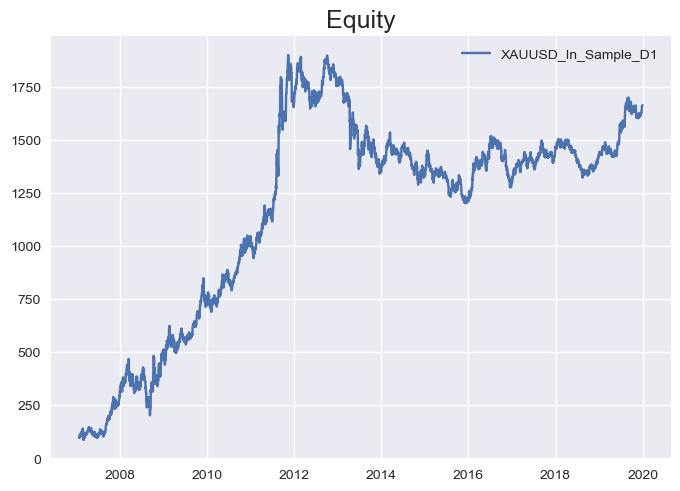

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                      682.699
Equity Peak [$]                       854.126
Return [%]                            582.699
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                   63.060687
Volatility (Ann.) [%]              179.734252
Sharpe Ratio                         0.350855
Sortino Ratio                        1.197782
Calmar Ratio                         0.853527
Max. Drawdown [%]                   -73.88244
Avg. Drawdown [%]                  -17.536103
Max. Drawdown Duration      567 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                                    9
Win Rate [%]                        66.666667
Best Trade [%]                      21.062839
Worst Trade [%]                     -8.542521
Avg. Trade [%]                    

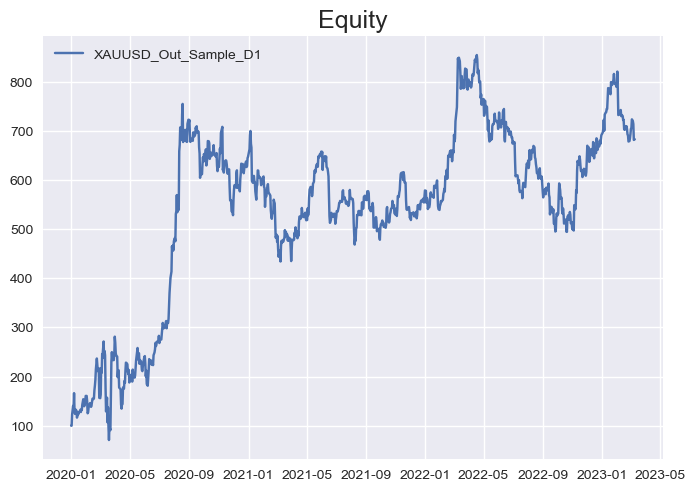

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [45]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [46]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [47]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [48]:
train

Start                     2007-01-04 08:00:00
End                       2019-12-31 20:00:00
Duration                   4744 days 12:00:00
Exposure Time [%]                   22.632008
Equity Final [$]                          0.0
Equity Peak [$]                        346.55
Return [%]                             -100.0
Buy & Hold Return [%]              141.990881
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              434.551653
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -7.995442
Max. Drawdown Duration     4311 days 04:00:00
Avg. Drawdown Duration       96 days 14:00:00
# Trades                                  761
Win Rate [%]                        69.908016
Best Trade [%]                       7.510226
Worst Trade [%]                    -18.283332
Avg. Trade [%]                    

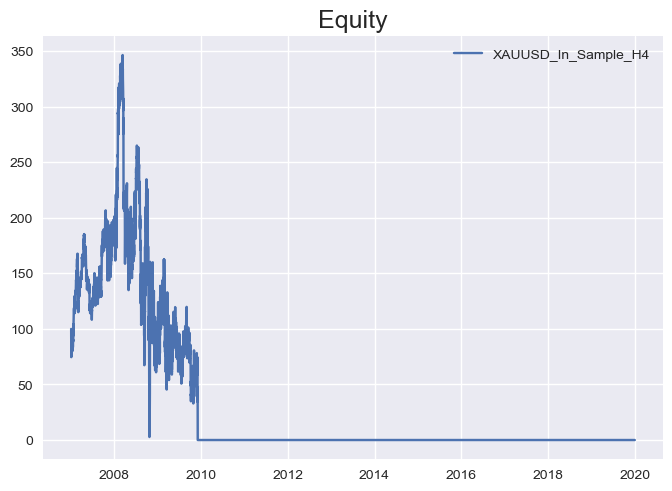

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                    4.486677
Equity Final [$]                          0.0
Equity Peak [$]                        101.68
Return [%]                             -100.0
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]          2382103.863967
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                    -50.5735
Max. Drawdown Duration     1163 days 04:00:00
Avg. Drawdown Duration      581 days 18:00:00
# Trades                                   50
Win Rate [%]                             76.0
Best Trade [%]                       0.460911
Worst Trade [%]                     -5.132041
Avg. Trade [%]                    

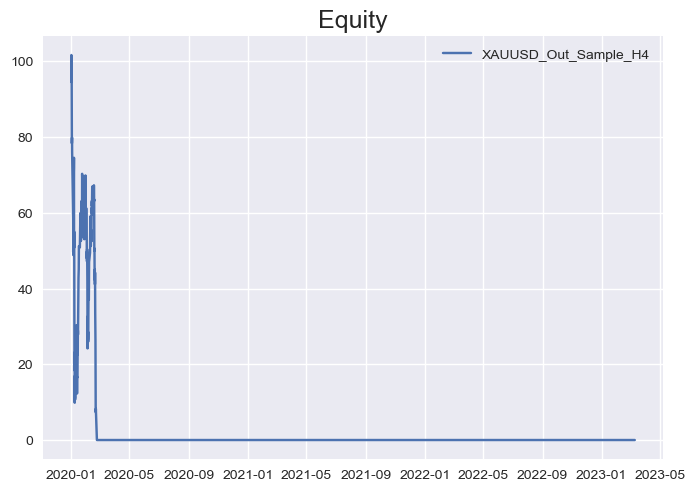

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [56]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [57]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [58]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [59]:
train

Start                     2007-01-01 20:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 01:00:00
Exposure Time [%]                   13.887519
Equity Final [$]                        4.745
Equity Peak [$]                       298.346
Return [%]                            -95.255
Buy & Hold Return [%]              138.603939
Return (Ann.) [%]                  -17.276249
Volatility (Ann.) [%]               84.653943
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.899781
Avg. Drawdown [%]                   -3.855136
Max. Drawdown Duration     4451 days 17:00:00
Avg. Drawdown Duration       42 days 09:00:00
# Trades                                 2919
Win Rate [%]                        64.302843
Best Trade [%]                       3.175076
Worst Trade [%]                     -7.492998
Avg. Trade [%]                    

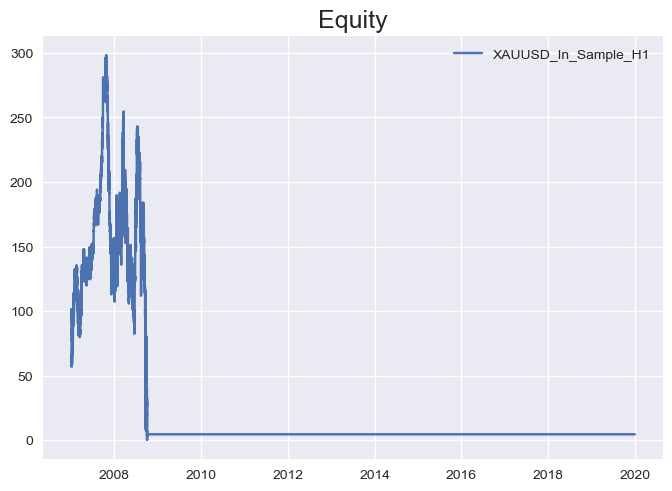

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                     0.57258
Equity Final [$]                          0.0
Equity Peak [$]                       105.953
Return [%]                             -100.0
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]        346383779.477898
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -21.856815
Max. Drawdown Duration     1162 days 22:00:00
Avg. Drawdown Duration      232 days 17:00:00
# Trades                                   25
Win Rate [%]                             56.0
Best Trade [%]                       0.238504
Worst Trade [%]                     -1.865705
Avg. Trade [%]                    

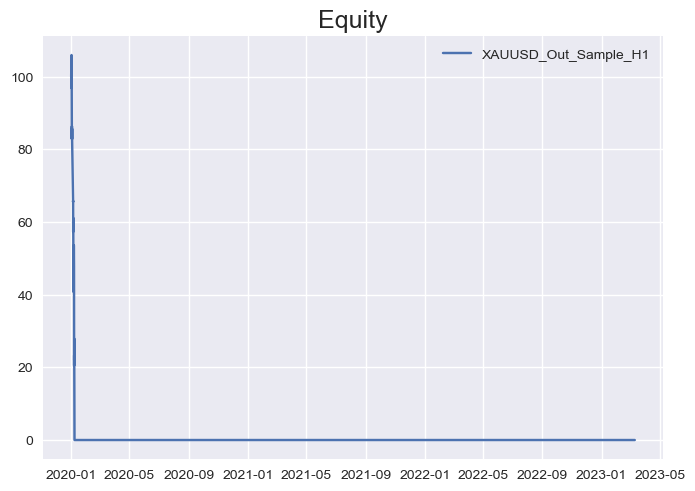

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [65]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [66]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [67]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [68]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [69]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17048\309472462.py:120: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [70]:
train

Start                     2007-01-01 10:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 11:30:00
Exposure Time [%]                   13.722453
Equity Final [$]                          0.0
Equity Peak [$]                       384.802
Return [%]                             -100.0
Buy & Hold Return [%]              138.590804
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              217.153531
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -2.435218
Max. Drawdown Duration     4442 days 06:00:00
Avg. Drawdown Duration       20 days 19:15:00
# Trades                                 6214
Win Rate [%]                        64.724815
Best Trade [%]                       1.758773
Worst Trade [%]                    -11.801523
Avg. Trade [%]                    

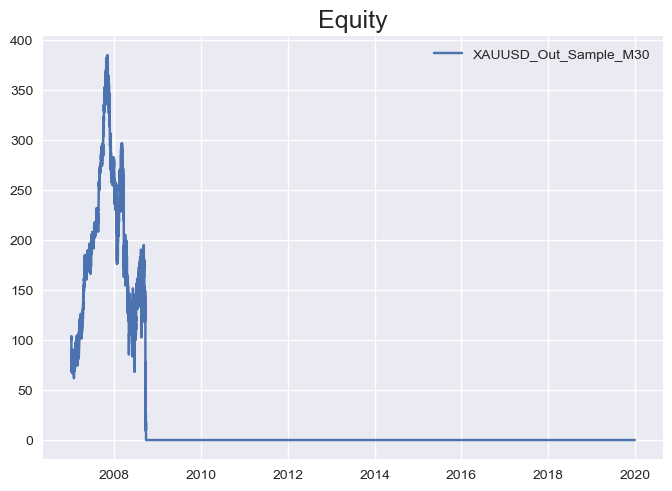

In [71]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [72]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1349.336
Equity Peak [$]                      1392.403
Return [%]                           1249.336
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                   93.810212
Volatility (Ann.) [%]              138.255668
Sharpe Ratio                         0.678527
Sortino Ratio                        2.442608
Calmar Ratio                         1.413157
Max. Drawdown [%]                  -66.383438
Avg. Drawdown [%]                   -2.187219
Max. Drawdown Duration      133 days 12:00:00
Avg. Drawdown Duration        3 days 06:53:00
# Trades                                 9992
Win Rate [%]                        67.103683
Best Trade [%]                       1.917718
Worst Trade [%]                     -5.327521
Avg. Trade [%]                    

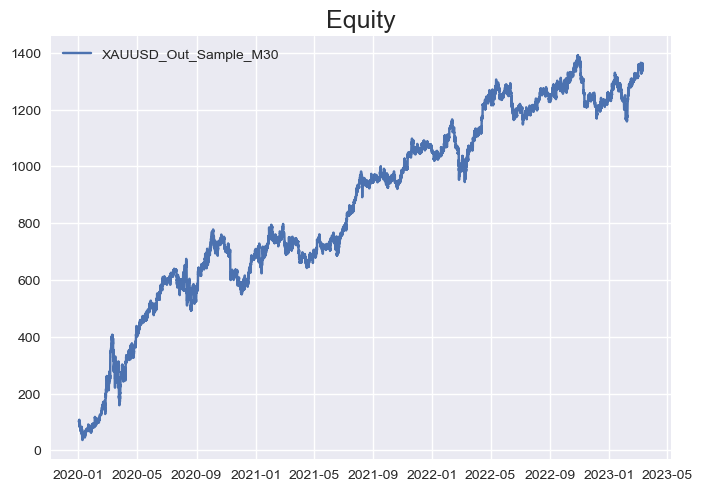

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [74]:
filename_train = f'result_{TF}_In_Sample.csv'

In [75]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [76]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [77]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [78]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [79]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [80]:
train, test = ml.Run()

: 

### In-Sample Backtesting

In [ ]:
train

Start                     2014-09-23 18:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 03:45:00
Exposure Time [%]                   99.998394
Equity Final [$]                     83743.15
Equity Peak [$]                       83743.6
Return [%]                          4087.1575
Buy & Hold Return [%]               24.022461
Return (Ann.) [%]                   77.391505
Volatility (Ann.) [%]               11.480871
Sharpe Ratio                         6.740909
Sortino Ratio                     3113.324793
Calmar Ratio                       236.772992
Max. Drawdown [%]                    -0.32686
Avg. Drawdown [%]                   -0.001486
Max. Drawdown Duration        3 days 06:15:00
Avg. Drawdown Duration        0 days 03:58:00
# Trades                                64792
Win Rate [%]                        98.635634
Best Trade [%]                       3.051941
Worst Trade [%]                     -1.220078
Avg. Trade [%]                    

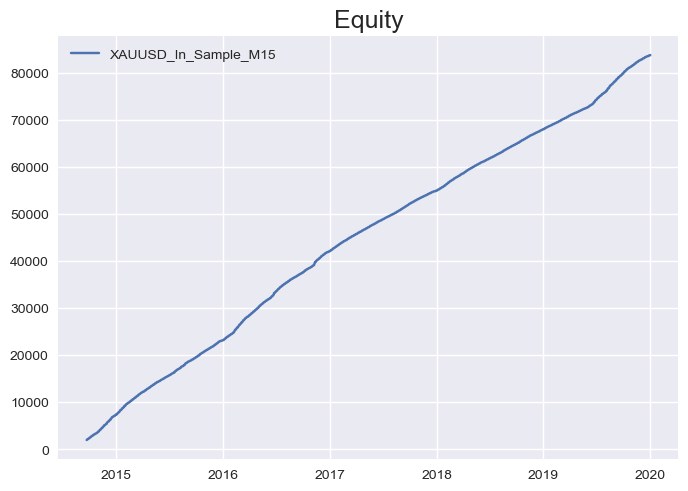

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2827.434
Equity Peak [$]                      2965.122
Return [%]                            41.3717
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                    9.214099
Volatility (Ann.) [%]               13.611846
Sharpe Ratio                         0.676918
Sortino Ratio                          1.0766
Calmar Ratio                         0.472695
Max. Drawdown [%]                   -19.49271
Avg. Drawdown [%]                   -0.371685
Max. Drawdown Duration      388 days 13:45:00
Avg. Drawdown Duration        2 days 22:08:00
# Trades                                15655
Win Rate [%]                        60.236346
Best Trade [%]                       1.834628
Worst Trade [%]                     -3.566473
Avg. Trade [%]                    

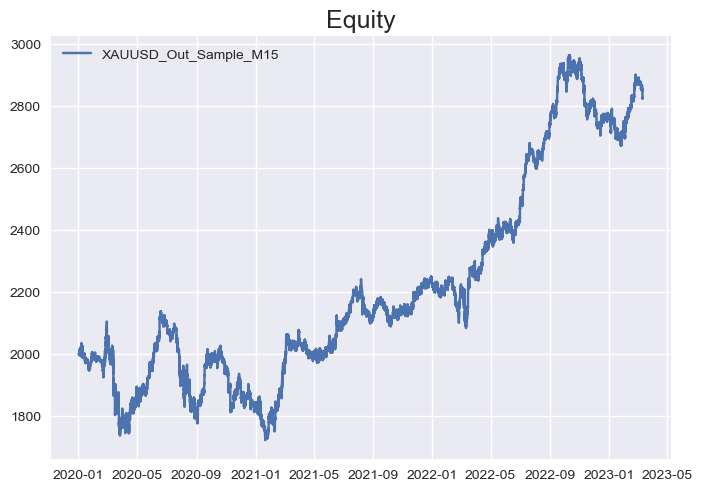

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_5100\1135718552.py:102: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [ ]:
train

Start                     2020-05-15 12:50:00
End                       2022-12-30 21:55:00
Duration                    959 days 09:05:00
Exposure Time [%]                   99.998928
Equity Final [$]                   130964.363
Equity Peak [$]                    130964.948
Return [%]                         6448.21815
Buy & Hold Return [%]                4.609869
Return (Ann.) [%]                  258.556268
Volatility (Ann.) [%]               55.756861
Sharpe Ratio                          4.63721
Sortino Ratio                      4069.14941
Calmar Ratio                       819.965327
Max. Drawdown [%]                   -0.315326
Avg. Drawdown [%]                   -0.000701
Max. Drawdown Duration        3 days 04:30:00
Avg. Drawdown Duration        0 days 01:11:00
# Trades                                95756
Win Rate [%]                        98.775011
Best Trade [%]                       2.888443
Worst Trade [%]                     -0.876337
Avg. Trade [%]                    

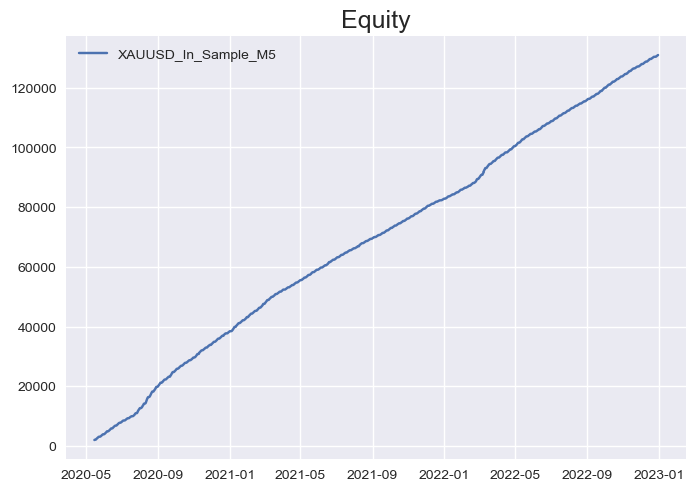

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:50:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                      2177.36
Equity Peak [$]                       2177.36
Return [%]                              8.868
Buy & Hold Return [%]                 2.07534
Return (Ann.) [%]                   43.962007
Volatility (Ann.) [%]               16.097365
Sharpe Ratio                         2.731006
Sortino Ratio                        7.037129
Calmar Ratio                         7.770619
Max. Drawdown [%]                   -5.657465
Avg. Drawdown [%]                   -0.207839
Max. Drawdown Duration       23 days 01:30:00
Avg. Drawdown Duration        0 days 11:06:00
# Trades                                 5908
Win Rate [%]                        52.928233
Best Trade [%]                       0.788545
Worst Trade [%]                     -1.676309
Avg. Trade [%]                    

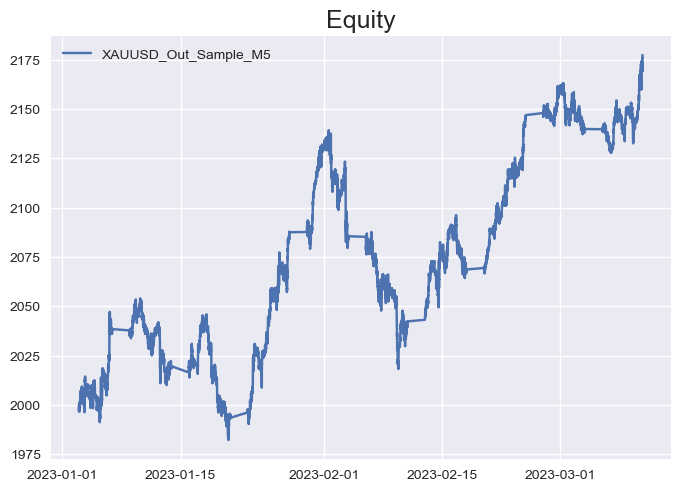

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


### In-Sample Backtesting

In [ ]:
train

Start                     2022-08-16 23:33:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:25:00
Exposure Time [%]                   99.997745
Equity Final [$]                    38774.185
Equity Peak [$]                     38774.608
Return [%]                         1838.70925
Buy & Hold Return [%]                2.713066
Return (Ann.) [%]                59089.862947
Volatility (Ann.) [%]            27772.123703
Sharpe Ratio                         2.127668
Sortino Ratio                             inf
Calmar Ratio                   1744949.371484
Max. Drawdown [%]                   -0.033863
Avg. Drawdown [%]                   -0.000499
Max. Drawdown Duration        3 days 01:08:00
Avg. Drawdown Duration        0 days 00:11:00
# Trades                                65853
Win Rate [%]                        96.698708
Best Trade [%]                        1.29732
Worst Trade [%]                     -0.378417
Avg. Trade [%]                    

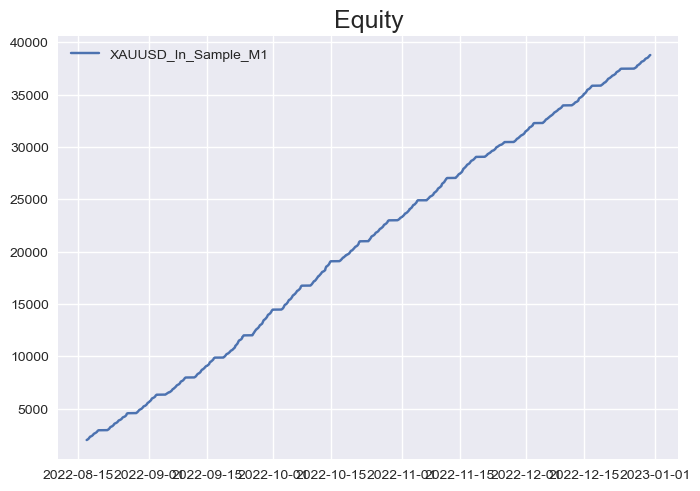

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:58:00
Duration                     66 days 18:58:00
Exposure Time [%]                   99.997013
Equity Final [$]                     2104.413
Equity Peak [$]                      2152.393
Return [%]                            5.22065
Buy & Hold Return [%]                2.050654
Return (Ann.) [%]                   25.500773
Volatility (Ann.) [%]               15.779802
Sharpe Ratio                         1.616039
Sortino Ratio                        3.440508
Calmar Ratio                          4.84993
Max. Drawdown [%]                   -5.257967
Avg. Drawdown [%]                   -0.141778
Max. Drawdown Duration       33 days 23:10:00
Avg. Drawdown Duration        0 days 06:32:00
# Trades                                 9559
Win Rate [%]                         56.60634
Best Trade [%]                       0.753748
Worst Trade [%]                      -1.39791
Avg. Trade [%]                    

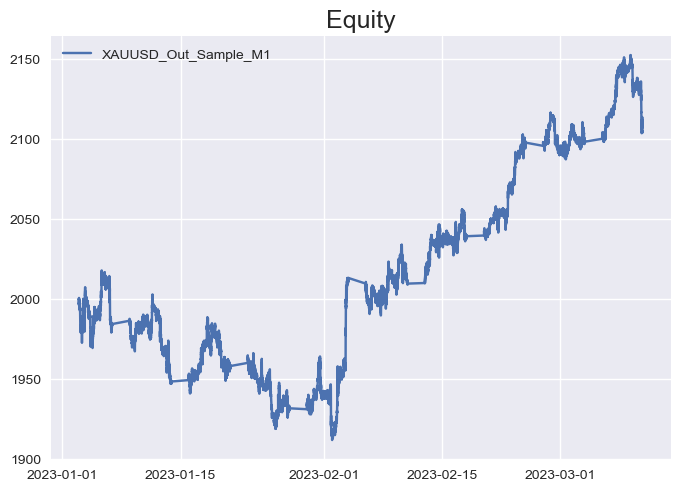

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')